In [1]:
from GenZ import decode_moddeling, prefill_moddeling

from GenZ.system import System
import pandas as pd
from GenZ.analye_model import get_model_df, get_summary_table

from GenZ.get_language_model import create_inference_mamba_prefix_model, create_inference_mamba_decode_model

In [2]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

In [3]:
system = System(frequency=1000 , flops=2000, off_chip_mem_size=(80*1024), compute_efficiency=0.8, memory_efficiency=0.8,
                     offchip_mem_bw=3500, bits='int8', external_mem_bw=128, interchip_mem_bw=256, interchip_link_latency=2)

In [4]:
################################################################################################## #
### Model Characterization Calculation
################################################################################################## #
model_prefill = create_inference_mamba_prefix_model(input_sequence_length=10000,output_gen_tokens = 0 ,
                                    name='state-spaces/mamba-130m-hf')

B = 1
model_df = get_model_df(model_prefill, system, batch_size=B,  model_characterstics = True)
summary_table = get_summary_table(model_df,system, model_characterstics = True)


In [5]:
display(model_df)
display(summary_table)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[1, 3072, 10000, 768]",1157.672596,47185.92,7.324219,2.25,29.296875,38.871094
1,CONV1D,"[1, 1536, 1536, 10000, 4]",3.9992,122.88,14.648438,0.005859,14.648438,29.302734
2,GEMM,"[1, 80, 10000, 1536]",150.931531,2457.6,14.648438,0.117188,0.762939,15.528564
3,GEMM,"[1, 1536, 10000, 48]",92.659621,1474.56,0.457764,0.070312,14.648438,15.176514
4,GEMM,"[1, 768, 10000, 1536]",974.12481,23592.96,14.648438,1.125,7.324219,23.097656


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,74833.92,121.976562,3.568359,3.568359,38.871094


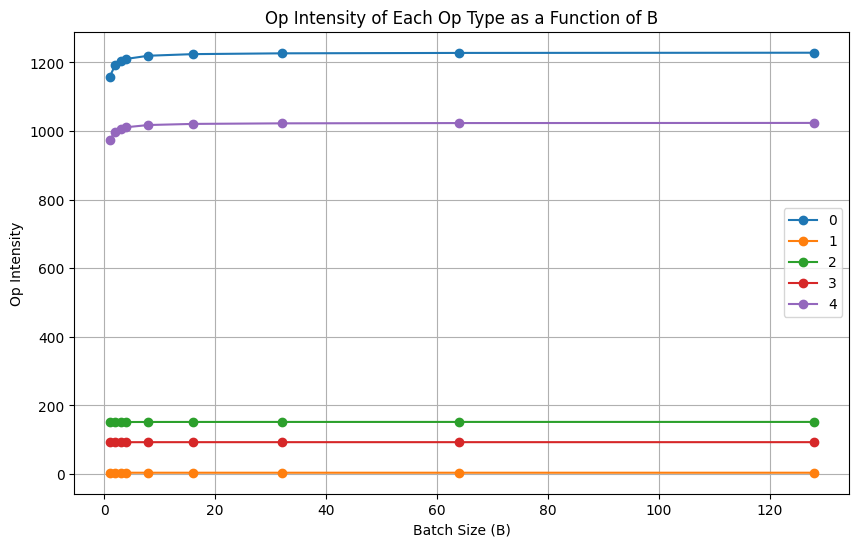

In [6]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store Op Intensity for each Op Type
op_intensity_data = {op_idx: [] for op_idx in range(len(model_df))}

# Vary B from 1 to 128
batch_sizes = [1,2,3,4,8,16,32,64,128]
for B in batch_sizes:
    model_df = get_model_df(model_prefill, system, batch_size=B, model_characterstics=True)
    for op_idx in range(len(model_df)):
        subset = model_df.loc[op_idx]
        op_intensity_data[op_idx].append(subset['Op Intensity'])

# Plotting
plt.figure(figsize=(10, 6))
for op_type, intensities in op_intensity_data.items():
    plt.plot(batch_sizes, intensities, marker='o', linestyle='-', label=op_type)

plt.xlabel('Batch Size (B)')
plt.ylabel('Op Intensity')
plt.title('Op Intensity of Each Op Type as a Function of B')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
################################################################################################## #
### Model Characterization Calculation
################################################################################################## #
model_decode = create_inference_mamba_decode_model(input_sequence_length=10000,output_gen_tokens = 0 ,
                                    name='state-spaces/mamba-130m-hf')

B = 1
model_df = get_model_df(model_decode, system, batch_size=B,  model_characterstics = True)
summary_table = get_summary_table(model_df,system, model_characterstics = True)


In [8]:
display(model_df)
display(summary_table)

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[1, 3072, 1, 768]",1.99675,4.718592,0.000732,2.25,0.00293,2.253662
1,CONV1D,"[1, 1536, 1536, 1, 4]",1.333333,0.012288,0.001465,0.005859,0.001465,0.008789
2,GEMM,"[1, 80, 1, 1536]",1.974039,0.24576,0.001465,0.117188,0.000076,0.118729
3,GEMM,"[1, 1536, 1, 48]",1.957935,0.147456,0.000046,0.070312,0.001465,0.071823
4,GEMM,"[1, 768, 1, 1536]",1.996101,2.359296,0.001465,1.125,0.000732,1.127197


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,7.483392,3.5802,3.568359,3.568359,2.253662


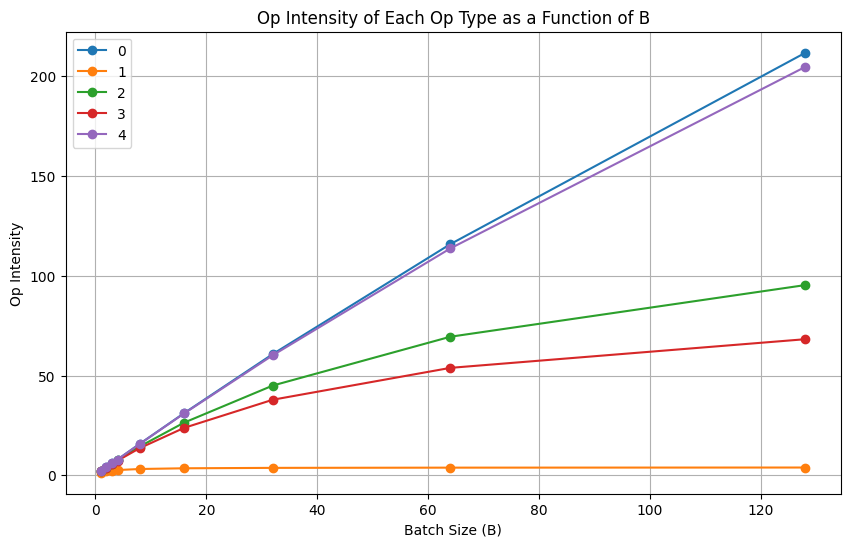

In [9]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store Op Intensity for each Op Type
op_intensity_data = {op_idx: [] for op_idx in range(len(model_df))}

# Vary B from 1 to 128
batch_sizes = [1,2,3,4,8,16,32,64,128]
for B in batch_sizes:
    model_df = get_model_df(model_decode, system, batch_size=B, model_characterstics=True)
    for op_idx in range(len(model_df)):
        subset = model_df.loc[op_idx]
        op_intensity_data[op_idx].append(subset['Op Intensity'])

# Plotting
plt.figure(figsize=(10, 6))
for op_type, intensities in op_intensity_data.items():
    plt.plot(batch_sizes, intensities, marker='o', linestyle='-', label=op_type)

plt.xlabel('Batch Size (B)')
plt.ylabel('Op Intensity')
plt.title('Op Intensity of Each Op Type as a Function of B')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model_df

,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,GEMM,"[128, 3072, 1, 768]",211.862069,603.979776,0.09375,2.25,0.375,2.71875
1,CONV1D,"[128, 1536, 1536, 1, 4]",3.938462,1.572864,0.1875,0.005859,0.1875,0.380859
2,GEMM,"[128, 80, 1, 1536]",95.403727,31.45728,0.1875,0.117188,0.009766,0.314453
3,GEMM,"[128, 1536, 1, 48]",68.266667,18.874368,0.005859,0.070312,0.1875,0.263672
4,GEMM,"[128, 768, 1, 1536]",204.8,301.989888,0.1875,1.125,0.09375,1.40625
